In [2]:
import data_generation as gen

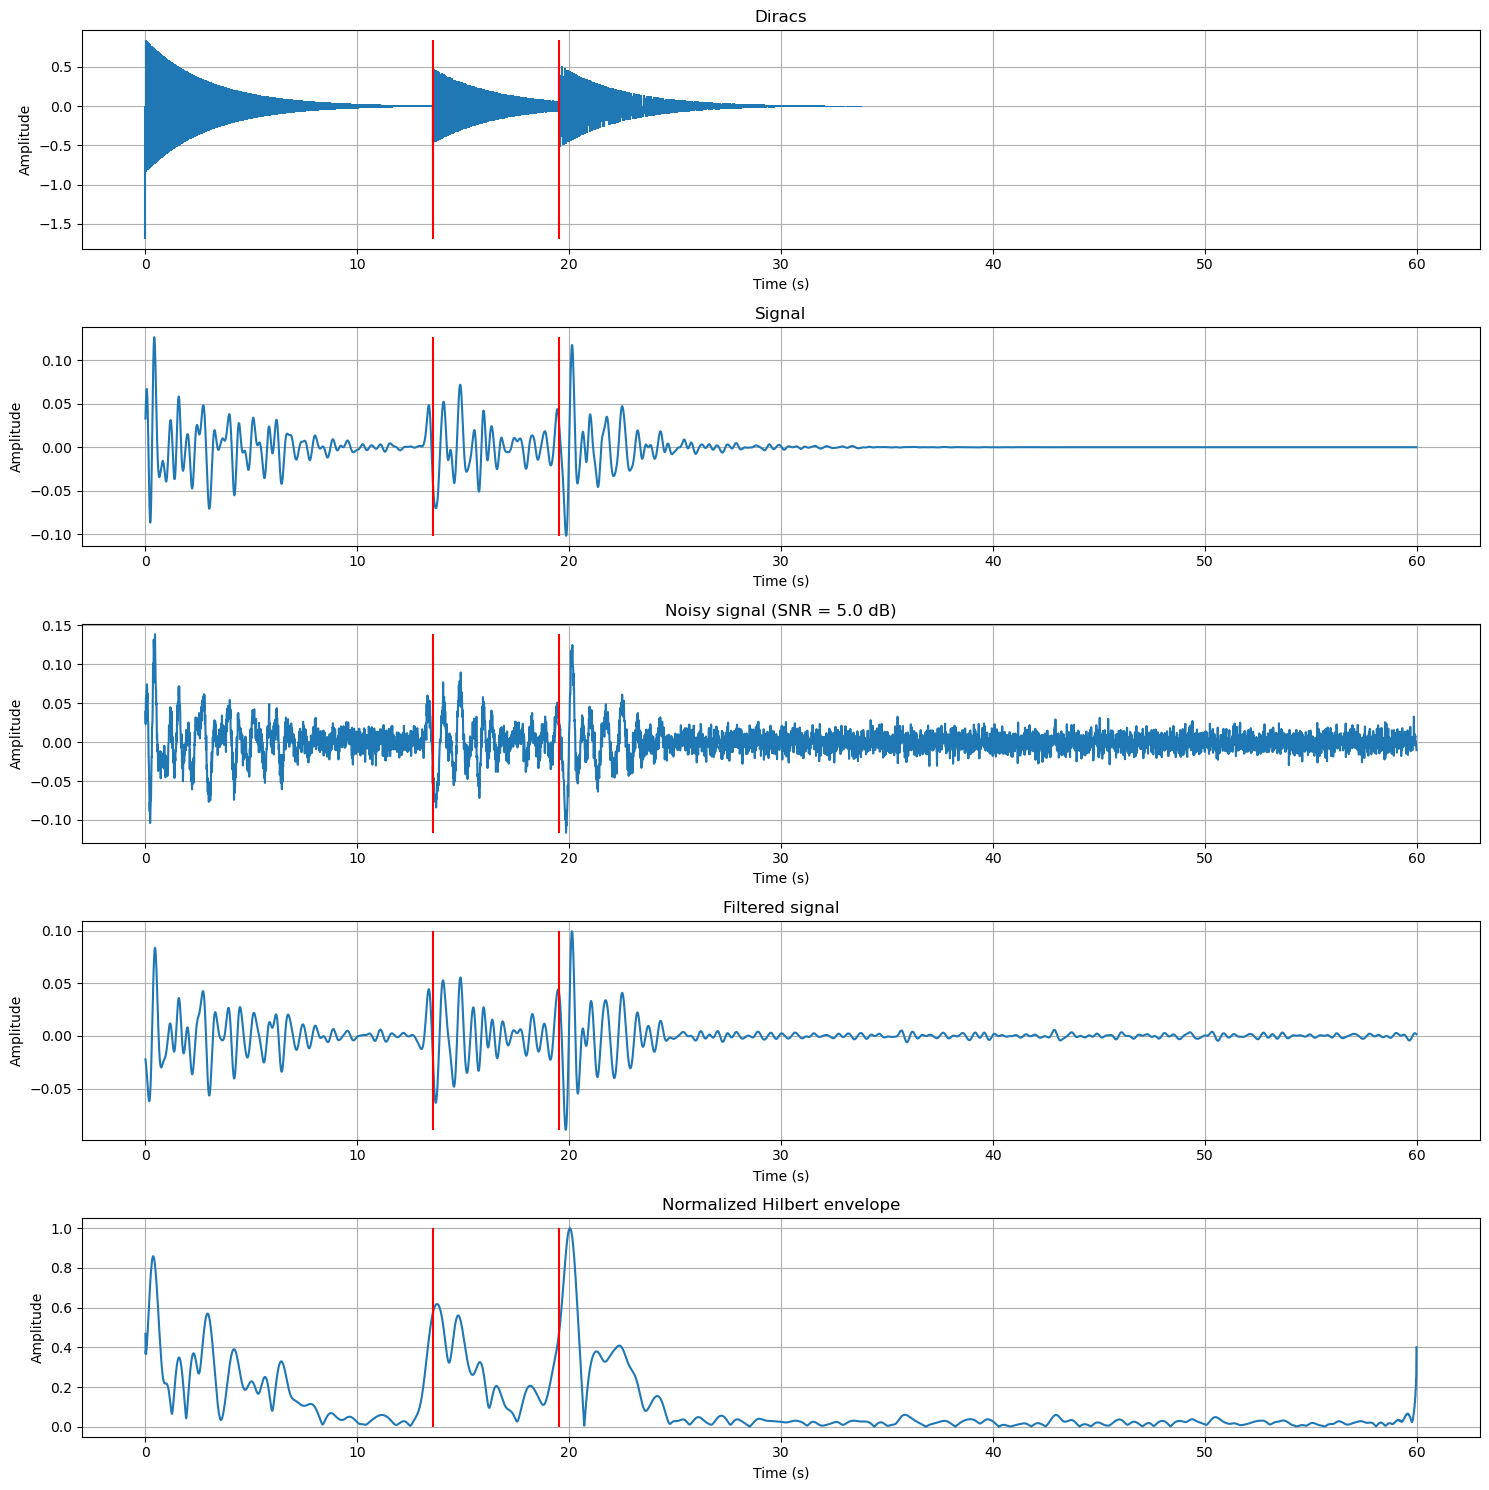

In [4]:
signal, source, station = gen.signal.generate_one_signal(plot=True)

## Model CNN

In [ ]:
# Initiate model
X_tensor, y_tensor, dataset, dataloader, model, criterion, optimizer = gen.crash_model.initiate_model()

In [ ]:
# Train model
gen.crash_model.train_model(model, dataloader, criterion, optimizer, epochs=20)

In [ ]:
# Test model
gen.crash_model.test_model(model)

## Tests pour utilisation de TauP

In [10]:
# Position de la source du séisme (latitude, longitude, profondeur en km)
source_lat = source[0]  # Latitude de la source
source_lon = source[1]  # Longitude de la source
source_depth = source[2]  # Profondeur de la source (en km)

# Position de la station (latitude et longitude)
station_lat = station[0][0]  # Latitude de la station
station_lon = station[0][1]  # Longitude de la station

In [14]:
P, pP, sP = gen.arrival_time.travel_times(source_lat, source_lon, source_depth, station_lat, station_lon)
tpP = pP - P
tsP = sP - P
print(f'P-pP: {tpP:.3f}s - P-sP: {tsP:.3f}s')

P-pP: 12.200s - P-sP: 18.666s


In [15]:
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

# Modèle de vitesse (par exemple, IASP91)
model = TauPyModel(model="ak135")

# Calcul de la distance angulaire entre la source et la station
distance_deg = locations2degrees(lat1=source_lat, long1=source_lon,
                                  lat2=station_lat, long2=station_lon)

# Calcul des temps d'arrivée pour les phases d'intérêt
arrivals = model.get_travel_times(source_depth_in_km=source_depth/1e3,
                                  distance_in_degree=distance_deg,
                                  phase_list=["P", "pP", "sP"])

# Affichage des résultats
for arrival in arrivals:
    print(f"Phase: {arrival.name}, Temps d'arrivée: {arrival.time:.3f} s")
    
tpP = arrivals[1].time - arrivals[0].time
tsP = arrivals[2].time - arrivals[0].time

print(f'P-pP: {tpP:.3f}s - P-sP: {tsP:.3f}s')

Phase: P, Temps d'arrivée: 492.990 s
Phase: pP, Temps d'arrivée: 510.596 s
Phase: sP, Temps d'arrivée: 518.672 s
P-pP: 17.606s - P-sP: 25.682s
